In [1]:
//  Copyright (c) 2020 Patrick Diehl
//
//  SPDX-License-Identifier: BSL-1.0
//  Distributed under the Boost Software License, Version 1.0. (See accompanying
//  file LICENSE_1_0.txt or copy at http://www.boost.org/LICENSE_1_0.txt)

# Exercise 1: Classical linear elasticity model

Let $\Omega = (0,1) \subset \mathbb R$ and $\overline{\Omega}$ be the closure of $\Omega$, i.e.\ $\Omega=[0,1]$. The continuum local problem consists in finding the displacement $(u\in\overline{\Omega})$ such that:
\begin{align}
\label{eq:1dlinearelasticity}
- E u''(x) = f_b(x), &\quad \forall x \in \Omega, \\
\label{eq:Dirichlet}
u(x) = 0, &\quad \text{at}\ x=0,\\
\label{eq:Neumann}
Eu'(x) = g, &\quad \text{at}\ x=1,
\end{align}
where $E$ is the constant modulus of elasticity of the bar, $f_b=f_b(x)$ is a scalar function describing the external body force density (per unit length), and $g \in \mathbb R$ is the traction force applied at end point $x=1$. 


In [2]:
#include <blaze/Math.h>
#include <BlazeIterative.hpp>
#include <cmath>
#include <iostream>
#include <vector>
#include<run_hpx.cpp>
#include<hpx/include/lcos.hpp>
#include<hpx/include/parallel_for_loop.hpp>

## Helpfer function for Blaze

[Blaze](https://bitbucket.org/blaze-lib/blaze/src/master/) is an open-source, high-performance C++ math library for dense and sparse arithmetic. This linrary has a HPX backend and utilzies the parallel algorithms to accelarted the linear algebara functions. Blaze is not covered in this cours and for more details we refer to

* K. Iglberger, G. Hager, J. Treibig, and U. Rüde: High Performance Smart Expression Template Math Libraries . Proceedings of the 2nd International Workshop on New Algorithms and Programming Models for the Manycore Era (APMM 2012) at HPCS 2012
* K. Iglberger, G. Hager, J. Treibig, and U. Rüde: Expression Templates Revisited: A Performance Analysis of Current Methodologies (Download). SIAM Journal on Scientific Computing, 34(2): C42--C69, 2012

In [3]:
// Generates a Blaze dynamic matrix of size N times N and fills the matrix with zeros
blaze::DynamicMatrix<double> zeroMatrix(unsigned long N)
{
return blaze::DynamicMatrix<double>( N, N, 0 );
};    

In [4]:
// Generates a Blaze dynamic vector of size N and fills the vector with zeros
blaze::DynamicVector<double> zeroVector(unsigned long N)
{
return blaze::DynamicVector<double>(N,0);
}; 

In [5]:
// Solves the matrix system A \times x = b and returns x
blaze::DynamicVector<double> solve(blaze::DynamicMatrix<double> A, blaze::DynamicVector<double> b )
{
     blaze::iterative::BiCGSTABTag tag;
     tag.do_log() = true;
     return solve(A,b,tag);
}

## Force function

As the external load, a linear $force_b$ function $force : \mathbb{R} \rightarrow \mathbb{R}$

 $$ force_b(x)  = \begin{cases} 1, if x == 1, \\
 0 , else\end{cases}, x = [0,1]$$

In [6]:
double force(double x){
    
    if ( x == 1 )
        return 1;
    
    return 0;
}

## Discretization

As the domain $\overline{\Omega}$ we consider the intervall $[0,1]$ and discretize the interval with $n$ elements and using the spacing $h=\frac{1}{n}$ such that $x={0,1\cdot h,2\cdot h,\ldots,n\cdot h}$.

In [7]:
size_t n = std::pow(2,2);
double h= 1./n;
n += 1;

(unsigned long) 5


In [8]:
auto x = zeroVector(n);
for(size_t i = 0 ; i < n ; i++)
    x[i] = i * h;

In [9]:
// Print the discrete nodes
std::cout << x ;

(           0 )
(        0.25 )
(         0.5 )
(        0.75 )
(           1 )


(std::ostream &) @0x7fcfdfe3b500


<span style="color:blue">Task 1: Replace the for loop in Cell 11 with the hpx::for loop to fill the right-hand side $f$ in parrallel in Cell 12</span>.


## Prepare the external load

In [10]:
// Get the force vector for the right-hand side
auto f = zeroVector(n);

In [11]:
/*
for(size_t i = 0 ; i < n  ; i++)
 {
  f[i] = force(x[i]);   
 }
*/

In [12]:
run_hpx([](){

hpx::for_loop(
	hpx::execution::par, 
	0, 
	n,
	[&](boost::uint64_t i)
		{
		   f[i] = force(x[i]); 
		}
	);
});

(void) @0x7fcfd4e74e48


In [22]:
// Print the force vector
std::cout << f ;

(           0 )
(           0 )
(           0 )
(           0 )
(           1 )


(std::ostream &) @0x7fcfdfe3b500


### Assemble the stiffness matrix using finite differences


1. Dirichlet boundary condition at $x=0$:
\begin{equation}
u_1 = 0.
\end{equation}
2. Finite difference schems for 
In $\overline{\Omega}$: 
$\forall i=2,\ldots,n-1$:
\begin{equation}
- E \frac{u_{i-1}-2u_i+u_{i+1}}{h^2} = f_b(x_k).
\end{equation}
3. Neumann boundary condition at $x=1$:
\begin{equation}
E \frac{u_{n-3}-4u_{n-2}+3u_n-1}{2h} = g.
\end{equation}

For simplicity we assume $E=1$.



<span style="color:blue">Task 2: Use aysnchronous programming to assemble the stiffness matrix using hpx::async and hpx::future</span>.

1. Finish the function assemble to fill the matrix from start to end in Cell 16
2. Generate a vector of hpx::futures<void> to collect all future for synchronization in Cell 17
3. Use hpx::async to execute the function assemble asynchronously in Cell 17
4. Use hpx::wait_all to syncrhonize the results in Cell 17

In [14]:
// Get the stiffness matrix filled with zeros
auto matrix = zeroMatrix(n);

In [15]:
/*
matrix(0,0) = 1;
for(size_t i = 1 ; i < n-1 ; i++){
    matrix(i,i-1) = -2;
    matrix(i,i) = 4;
    matrix(i,i+1) = -2;
    }

matrix(n-1,n-1) = 3*h;
matrix(n-1,n-2) = -4*h;    
matrix(n-1,n-3) = h;

matrix *= 1./(2*h*h);
*/

In [16]:
// Assmeble the part of the stiffness matrix where the index goes from start to end
void assemble(blaze::DynamicMatrix<double>* matrix, size_t start, size_t end)
{
    
    for(size_t i = start ; i < end ; i++)
    {
        (*matrix)(i,i-1) = -2;
        (*matrix)(i,i) = 4;
        (*matrix)(i,i+1) = -2;
    }
}

In [17]:
run_hpx([&](){

matrix(0,0) = 1;

std::vector<hpx::future<void>> futures;

futures.push_back(hpx::async(assemble,&matrix,1,std::round(float(n)/2)));
futures.push_back(hpx::async(assemble,&matrix,std::round(float(n)/2),n-1));

hpx::wait_all(futures);

matrix(n-1,n-1) = 3*h;
matrix(n-1,n-2) = -4*h;    
matrix(n-1,n-3) = h;
    
    
matrix *= 1./(2.*h*h);
    
});

(void) @0x7fcfd4e74e48


In [18]:
std::cout << matrix ;

(            8            0            0            0            0 )
(          -16           32          -16            0            0 )
(            0          -16           32          -16            0 )
(            0            0          -16           32          -16 )
(            0            0            2           -8            6 )


(std::ostream &) @0x7fcfdfe3b500


In [19]:
// Solve the matrix system matrix times displacement - f
auto displacement = solve(matrix,f);

In [20]:
std::cout << displacement;

(           0 )
(        0.25 )
(         0.5 )
(        0.75 )
(           1 )


(std::ostream &) @0x7fcfdfe3b500


# Doing python plots from C++ 

Doing plots in Python is quite convinent using [matplotlib](https://matplotlib.org/), however, plotting in C++ is a little bit more tricky since we need to write the data as a CSV file and use Python or Matplotlib to plot it. The notebooks have some magic implemented to plot C++ variables directly in Python's matplotlib. 

Below we use %plot x y to plot a new line and we can repeat this command to add new lines to the same plot. Using %plotc x y will plot all previous added lines and clear the figure.


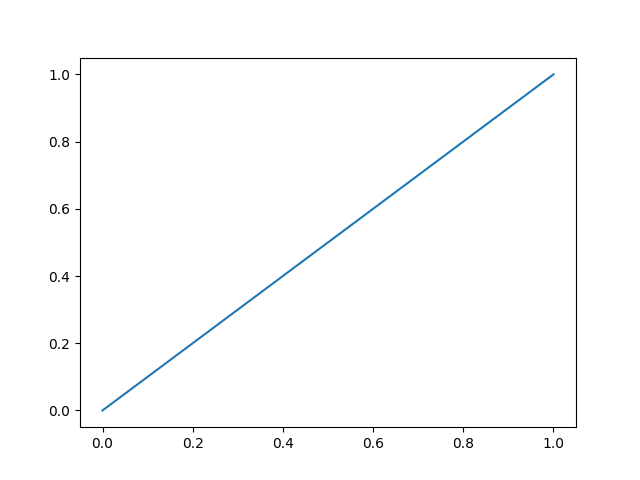

In [21]:
%plot x displacement
%plotc x x